# Data Scraper

Use this Notebook to scrape data from Lazy ETF Website which contains rich historical data for different kinds of portfolios

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from os import path
from datetime import datetime, timedelta
from scipy.stats import norm

In [3]:
def convert_yearly_return_to_numeric(yearly_return_string):
    
    #Check if it is a positive return
    if '+' in yearly_return_string:
        yearly_return_string = yearly_return_string.replace('+', '')
        yearly_return_numeric = float(yearly_return_string)
        yearly_return_numeric = (100 + yearly_return_numeric)/100
        
    else:
        yearly_return_string = yearly_return_string.replace('-', '')
        yearly_return_numeric = float(yearly_return_string)
        yearly_return_numeric = (100 - yearly_return_numeric)/100
    
    return yearly_return_numeric
    

In [4]:
def find_yearly_returns(soup):
    
    result = []
    
    html_table = soup.find('table', id='yearReturns')
    html_table_tbody = html_table.find('tbody')
    html_table_tbody_rows = html_table_tbody.findAll('tr')
    
    for row in html_table_tbody_rows:
        current_year = row.find('td').text
        total = convert_yearly_return_to_numeric(row.find_all('td')[1].text)
        inflation_adjusted = convert_yearly_return_to_numeric(row.find_all('td')[2].text)
        result.append({'year': current_year, 'inflation_adjusted': inflation_adjusted, 'total': total})
        
    return result

In [5]:
def fetch_portfolio_results(portfolio_name):
    base_url = "http://www.lazyportfolioetf.com/allocation"
    portfolio = "stocks-bonds-60-40"
    url = f"{base_url}/{portfolio_name}/"

    req = requests.get(url)
    soup = BeautifulSoup(req.text, "html.parser")
    
    df = pd.DataFrame(find_yearly_returns(soup))
    df['year'] = pd.DatetimeIndex(df['year']).year

    return df

In [7]:
def read_portfolio_results(portfolio_name):
    
    file = r'data/' + portfolio_name + '.csv'
    
    try:
        df = pd.read_csv(file, index_col=None, header=0)
        return df
    except:
        print(f"Data for portfolio {portfolio_name} not found locally...Will scrape it from Lazy ETF")
        df = fetch_portfolio_results(portfolio_name)
        df.to_csv(f"data/{portfolio_name}.csv")
        return df

# Start simulations
Run simulations for withdrawing n % of money from the portfolio each year

In [46]:
#Set start date, number of years, withdrawal rate, etc.
start_year = datetime(1871, 1, 1).year
end_year = datetime(1972,1 , 1).year
withdrawal_rates = [0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
number_of_years_to_withdraw = 50
portfolio_start_value = 500000

portfolios = ['stocks-bonds-40-60', 'stocks-bonds-60-40', 'stocks-bonds-80-20', 'harry-browne-permanent', 'us-stocks', 'gold', 'stocks-bonds-20-80']

In [9]:
def forward_fill_portfolio_value(df, start_year, end_year, withdrawal_rate, portfolio_start_value):
    for i in range(start_year, end_year + 1):
        df.loc[i, 'portfolio_value'] = (df.loc[i-1, 'portfolio_value'] * df.loc[i, 'inflation_adjusted'])
        df.loc[i, 'portfolio_value'] = df.loc[i, 'portfolio_value'] - (portfolio_start_value * withdrawal_rate)
    df = df.set_index(df['year'])
    return df

In [49]:
def withdraw_for_n_years(df, start_year, end_year, withdrawal_rate, portfolio_start_value, portfolio_name):
    
    df = df[df['year'] <= end_year]
    df = df[df['year'] >= start_year]
    df = df.set_index(df['year'])

    df.loc[start_year, 'portfolio_value'] = portfolio_start_value
    df = forward_fill_portfolio_value(df, start_year + 1, end_year, withdrawal_rate, portfolio_start_value)
    #display(df)
    df = df[df['portfolio_value'] >= (portfolio_start_value * withdrawal_rate)]
    #years_survived = relativedelta(df['Date'].iloc[-1], df['Date'].iloc[0]).years
    
    if(len(df) == 0):
        return {"start_date": start_date, "end_date": None, "years_survival": 0}
    
    return {"start_date": df.iloc[-1]['year'], "end_date": df.iloc[0]['year'], "years_survival": len(df) - 1, "portfolio_end_value": df.iloc[0]['portfolio_value'], "portfolio_name": portfolio_name, "withdrawal_rate": withdrawal_rate}

In [50]:
result = []

for withdrawal_rate in withdrawal_rates:
    
    print(f"Running simulations with withdrawal rate: {withdrawal_rate * 100}%")

    for portfolio_name in portfolios:
  
        print(f"Running simulations on portfolio: {portfolio_name}")
    
        df = fetch_portfolio_results(portfolio_name)

        for current_year in range(start_year, end_year):
    
            result.append(withdraw_for_n_years(df, current_year, current_year + number_of_years_to_withdraw, withdrawal_rate, portfolio_start_value, portfolio_name))
    
results_df = pd.DataFrame(result)

display(results_df.groupby(['portfolio_name', 'withdrawal_rate']).agg({'years_survival' : ['mean', 'min', 'max', 'median']}))
display(results_df.groupby(['portfolio_name', 'withdrawal_rate']).agg({'portfolio_end_value' : ['mean', 'min', 'max', 'median']}))

Running simulations with withdrawal rate: 0.02
Running simulations on portfolio: stocks-bonds-40-60
Running simulations on portfolio: stocks-bonds-60-40


KeyboardInterrupt: 

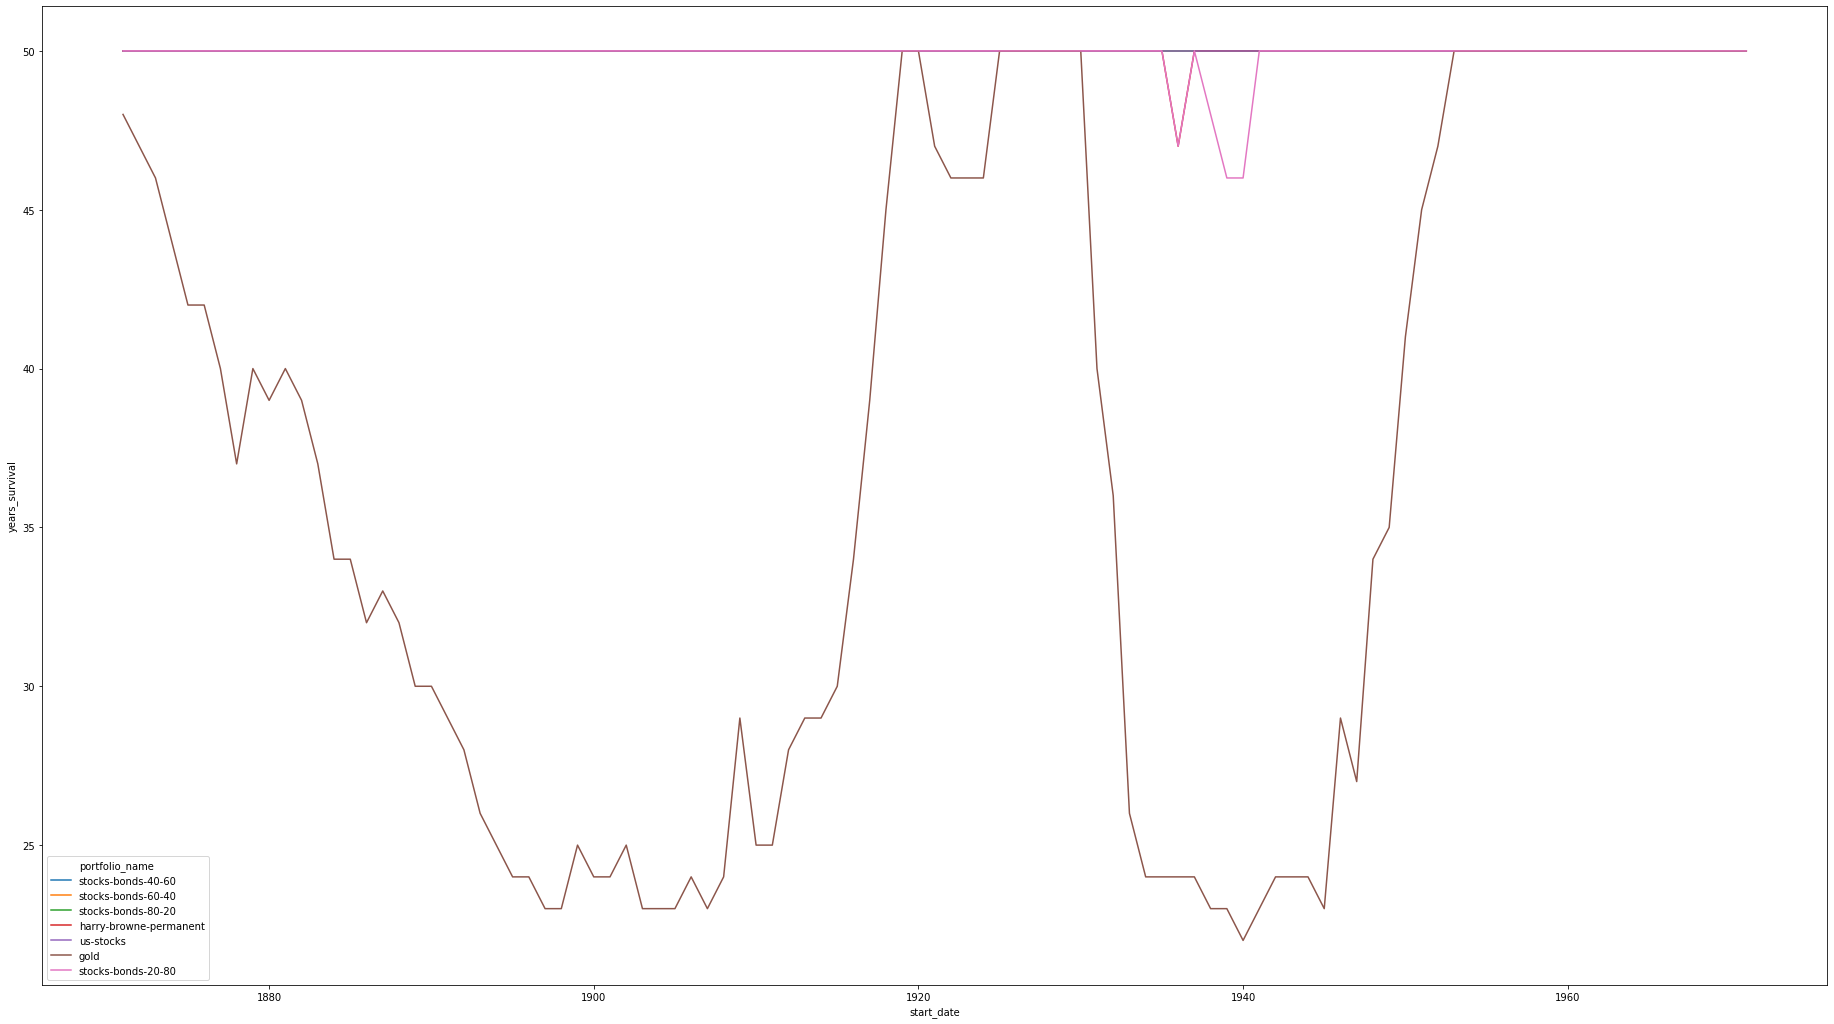

In [44]:
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=results_df) 
plt.show()

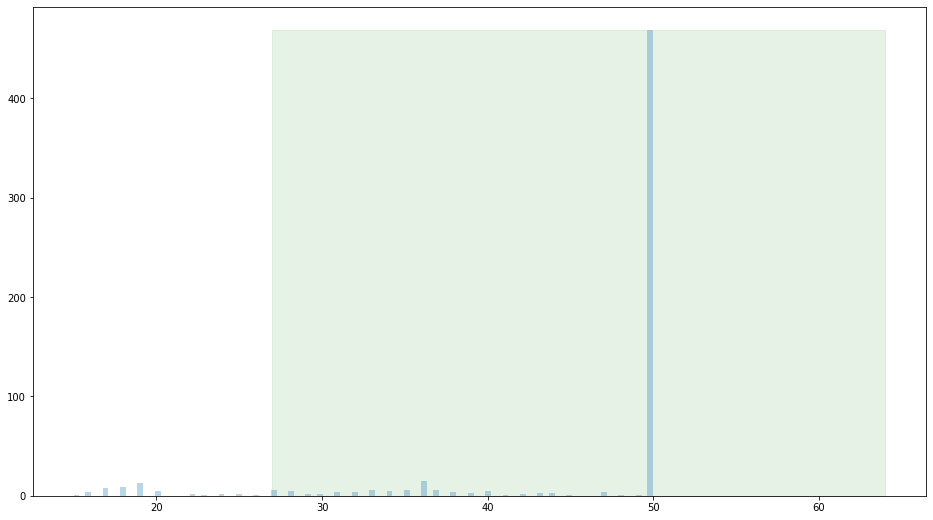

In [288]:
test_df = results_df
arr = test_df['years_survival']
plt.figure(figsize=(16,9))
ci = norm(*norm.fit(arr)).interval(0.95)  # fit a normal distribution and get 95% c.i.
height, bins, patches = plt.hist(arr, alpha=0.3, bins=100)
plt.fill_betweenx([0, height.max()], ci[0], ci[1], color='g', alpha=0.1)